## 1. Configuration de l’environnement

Cette cellule monte Google Drive pour accéder à ton `kaggle.json`, installe la CLI Kaggle et place ta clé API au bon endroit pour pouvoir télécharger le dataset.


In [ ]:
# 1.1 Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 1.2 Installer la CLI Kaggle
!pip install -q kaggle

# 1.3 Copier ton fichier kaggle.json (clé API) depuis Drive
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Vérification (optionnelle) : liste du dossier .kaggle
!ls -l ~/.kaggle

Mounted at /content/drive
total 4
-rw------- 1 root root 62 Apr 30 14:34 kaggle.json


## 2. Téléchargement & Importation du dataset

Cette cellule utilise la CLI Kaggle pour télécharger le jeu d’images IRM depuis Kaggle, puis décompresse l’archive dans le dossier `/content/brain_tumor_dataset`.


In [ ]:
# 2.1 Télécharger le dataset depuis Kaggle dans /content
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection -p /content

# 2.2 Créer le dossier de destination
!mkdir -p /content/brain_tumor_dataset

# 2.3 Dézipper l’archive
!unzip -q /content/brain-mri-images-for-brain-tumor-detection.zip -d /content/brain_tumor_dataset

# 2.4 Vérification rapide : lister les sous-dossiers
!ls /content/brain_tumor_dataset

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
brain_tumor_dataset  no  yes


In [ ]:
import os
print(os.listdir('/content/brain_tumor_dataset'))

['no', 'yes', 'brain_tumor_dataset']


## 3. Analyse des données

### 3.1 Charger toutes les images et construire `X` et `y`

Dans cette cellule, on va :

1. Récupérer les chemins vers toutes les images IRM avec et sans tumeur.  
2. Afficher le nombre d’exemples disponibles par classe.  
3. Charger chaque image en niveaux de gris, la redimensionner à 128×128 et l’ajouter au tableau `X`.  
4. Construire le vecteur de labels `y` (1 = tumeur, 0 = normal).


In [ ]:
import cv2
import numpy as np
from glob import glob

# 3.1 Récupérer les chemins
yes_paths = glob('/content/brain_tumor_dataset/yes/*.jpg')
no_paths  = glob('/content/brain_tumor_dataset/no/*.jpg')

print("Nombre d'IRM avec tumeur :", len(yes_paths))
print("Nombre d'IRM sans tumeur  :", len(no_paths))

# 3.2 Charger et redimensionner
X, y = [], []
for p in yes_paths:
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128,128))
    X.append(img)
    y.append(1)
for p in no_paths:
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128,128))
    X.append(img)
    y.append(0)

# 3.3 Conversion en tableaux NumPy
X = np.array(X)
y = np.array(y)

print("Shape de X :", X.shape)
print("Shape de y :", y.shape)

Nombre d'IRM avec tumeur : 86
Nombre d'IRM sans tumeur  : 85
Shape de X : (171, 128, 128)
Shape de y : (171,)


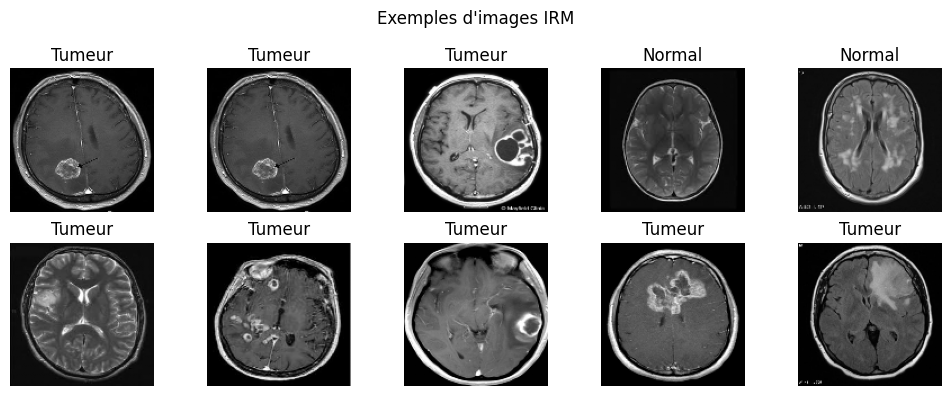

In [ ]:
#3.4 Afficher quelques exemples aléatoires
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(10,4))
for i, idx in enumerate(random.sample(range(len(X)), 10)):
    plt.subplot(2,5,i+1)
    plt.imshow(X[idx], cmap='gray')
    plt.title("Tumeur" if y[idx]==1 else "Normal")
    plt.axis('off')
plt.suptitle("Exemples d'images IRM")
plt.tight_layout()
plt.show()

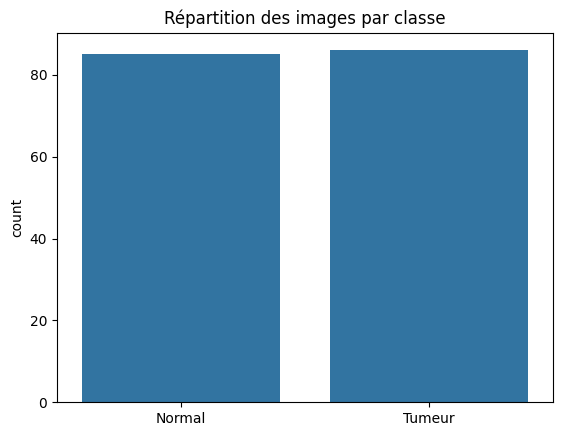

In [ ]:
#3.5 Distribution des classes
import seaborn as sns

sns.countplot(x=y)
plt.xticks([0,1], ['Normal','Tumeur'])
plt.title("Répartition des images par classe")
plt.show()

## 4. Préparation des jeux d’entraînement et de test

On ajoute la dimension canal à `X` puis on sépare les données en 80 % pour l’entraînement et 20 % pour le test, en conservant la proportion de classes (`stratify=y`).


In [ ]:
from sklearn.model_selection import train_test_split

# 4.1 Reshape X pour ajouter la dimension « canal »
X = X.reshape(-1, 128, 128, 1)

# 4.2 Split 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print("Train :", X_train.shape, y_train.shape)
print("Test  :", X_test.shape,  y_test.shape)

Train : (136, 128, 128, 1) (136,)
Test  : (35, 128, 128, 1) (35,)


## 5. Définition et compilation du modèle CNN

Dans cette cellule, on définit l’architecture du réseau de neurones convolutif pour classer chaque image IRM :  
- Deux blocs convolution + pooling  
- Une couche fully connected avec dropout  
- Activation sigmoïde pour la sortie binaire  

On compile ensuite le modèle avec l’optimiseur Adam, la perte `binary_crossentropy` et la métrique d’accuracy, puis on affiche son résumé.

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,705,345 (14.13 MB)

 Trainable params: 3,705,345 (14.13 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Entraînement du modèle

Entraînement du CNN sur les données d’entraînement pour 10 époques, avec un batch size de 16 et une validation interne de 10 % pour suivre l’évolution de la perte et de l’accuracy.


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.1  # 10% des données d'entraînement pour val
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step - accuracy: 0.5337 - loss: 108.0246 - val_accuracy: 0.8571 - val_loss: 1.8635
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7547 - loss: 11.0583 - val_accuracy: 0.8571 - val_loss: 1.5621
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7747 - loss: 2.0989 - val_accuracy: 0.8571 - val_loss: 0.4080
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8366 - loss: 0.6254 - val_accuracy: 0.9286 - val_loss: 0.2435
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8904 - loss: 0.2852 - val_accuracy: 1.0000 - val_loss: 0.1382
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9512 - loss: 0.1544 - val_accuracy: 1.0000 - val_loss: 0.0689
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9419 - loss: 0.1286 - val_accuracy: 1.0000 - val_loss: 0.1070
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9802 - loss: 0.0699 - val_accuracy: 1.0000 - val_loss: 0.0

## 7. Évaluation sur l’ensemble de test

Dans cette cellule, on évalue la performance finale du modèle sur les données de test jamais vues pendant l’entraînement et la validation interne.


In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step - accuracy: 0.7747 - loss: 1.0553
Test Accuracy: 77.14%


## 8. Matrice de confusion et rapport de classification

Ici, on génère les prédictions binaires sur l’ensemble de test et on affiche :
- la **matrice de confusion** pour voir les vraies/faux positifs et négatifs  
- le **rapport de classification** (précision, rappel, F1-score) pour chaque classe

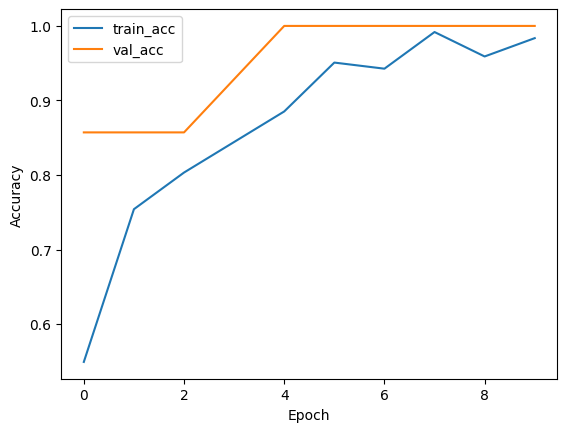

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# 8.1 Prédictions binaires (seuil 0.5)
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# 8.2 Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :\n", cm)

# 8.3 Rapport de classification
print("\nRapport de classification :")
print(classification_report(
    y_test, y_pred,
    target_names=["Normal", "Tumeur"]
))

## 9. Sauvegarde et rechargement du modèle

Cette cellule montre comment **sauvegarder** le modèle entraîné au format natif Keras, puis le **recharger** ultérieurement pour l’utiliser sans devoir le réentraîner.

In [ ]:
# 9.1 Sauvegarde du modèle au format natif Keras
model.save('/content/brain_tumor_model.keras')

In [ ]:
# 9.2 Rechargement du modèle pour une utilisation future
from tensorflow.keras.models import load_model
model = load_model('/content/brain_tumor_model.keras')

## 10. Test de la fonction de prédiction

On teste la fonction `predict_and_show` sur des exemples d’images IRM issues des répertoires `yes` et `no` pour vérifier qu’elle identifie correctement les cas « Tumeur » et « Normal ».

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# 10.1 Fonction de prédiction sur fichier
def predict_and_show(img_path):
    # Charger et préparer
    img = image.load_img(img_path, color_mode='grayscale', target_size=(128,128))
    arr = image.img_to_array(img) / 255.0
    arr = np.expand_dims(arr, 0)
    # Prédiction
    p = model.predict(arr)[0][0]
    label = "Tumeur" if p > 0.5 else "Normal"
    # Affichage
    plt.imshow(img, cmap='gray')
    plt.title(f"{label} ({p:.2f})")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


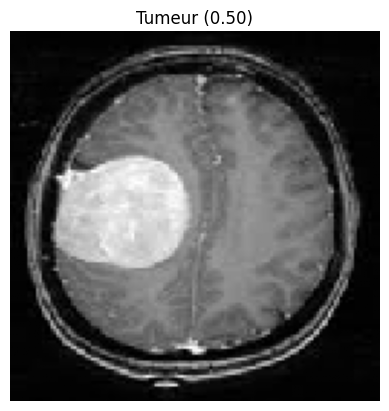

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


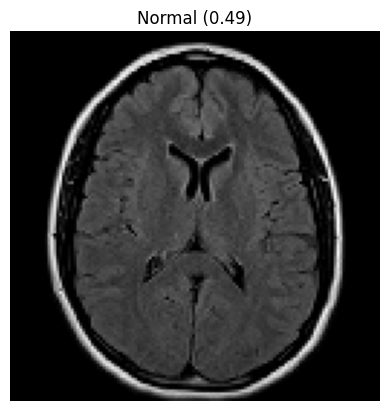

In [ ]:
# 10.2 Test sur une image avec tumeur
predict_and_show(yes_paths[0])

# 10.3 Test sur une image sans tumeur
predict_and_show(no_paths[0])